In [42]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import sklearn.metrics as smt

from xgboost import XGBClassifier

from scipy.stats import uniform, randint, genexpon

### Load and prepare data

In [2]:
train_df = pd.read_csv('hip_hop_train.csv', sep='|')
dev_df = pd.read_csv('nor_hip_hop_dev.csv', sep='|')
test_df = pd.read_csv('nor_hip_hop_test.csv', sep='|')

In [3]:
print('Dataset size is {} for training set, {} for dev set, and {} for test set.'.format(train_df.shape[0], dev_df.shape[0], test_df.shape[0]))

Dataset size is 5250 for training set, 3013 for dev set, and 3050 for test set.


In [4]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]
# Shuffle data to ungroup class rows
train = train_df[features+['label']].copy()
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
dev = dev_df[features+['label']].copy()
dev = dev.sample(frac=1, random_state=42).reset_index(drop=True)
test = test_df[features+['label']].copy()
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

Combine train and dev into one df X_train with train and dev labelled so they can be used together in cross-validation

In [5]:
train['dev_flag'] = -1
dev['dev_flag'] = 0

X_train = pd.concat([train, dev]).reset_index()
X_train.drop(columns=['index'], inplace=True)
y_train = X_train.pop('label')

In [6]:
X_train.nunique()

danceability               839
energy                     975
speechiness               1312
acousticness              2737
instrumentalness          2810
liveness                  1403
valence                   1110
num_samples               7163
end_of_fade_in            3366
loudness                  5937
tempo                     7647
key                         12
mode                         2
bars_num                   370
bars_duration_var         8209
beats_duration_var        8209
sections_num                45
sections_duration_mean    8142
sections_duration_var     8208
loudness_var              8208
tempo_var                 8205
key_var                   3649
mode_var                   140
segments_duration_var     8222
segments_duration_mean    8222
pitches_mean              8223
pitches_var               8223
timbre_mean               8224
timbre_var                8224
tatums_duration_var       8209
dev_flag                     2
dtype: int64

In [7]:
num_cols = [
            'bars_num',                
            'bars_duration_var',       
            'beats_duration_var',      
            'sections_num',            
            'sections_duration_mean',  
            'sections_duration_var',   
            'loudness_var',            
            'tempo_var',               
            'key_var',                 
            'mode_var',                
            'segments_duration_var',   
            'segments_duration_mean',  
            'pitches_mean',            
            'pitches_var',             
            'timbre_mean',             
            'timbre_var',              
            'tatums_duration_var',
            'danceability',             
            'energy',                   
            'speechiness',              
            'acousticness',             
            'instrumentalness',         
            'liveness',                 
            'valence',                  
            'num_samples',              
            'end_of_fade_in',           
            'loudness',                 
            'tempo'
           ]

cat_cols = ['key', 'mode']

In [8]:
y_train.value_counts()

0    4805
1    3458
Name: label, dtype: int64

In [9]:
hip_hop_tracks = y_train.value_counts()[1]
print(hip_hop_tracks)
other_tracks = y_train.value_counts()[0]
print(other_tracks)

ratio = other_tracks / hip_hop_tracks
print(ratio)

3458
4805
1.3895315211104684


In [10]:
encoder = OneHotEncoder(handle_unknown='ignore')
imputer = SimpleImputer(strategy='mean')
cat_pre = Pipeline(steps=[('imp1', imputer), ('enc', encoder)])
preprocessor = ColumnTransformer([('cat', cat_pre, cat_cols), ('imp2', imputer, num_cols)], remainder='drop')
classifier = XGBClassifier(scale_pos_weight=ratio, verbosity=0, label_encoder=False)

model_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', classifier)])

In [11]:
# Set up cross validation with Random Search

ps = PredefinedSplit(X_train['dev_flag'])

distributions = {
                 'clf__learning_rate': genexpon(1,10,10),
                 'clf__gamma': genexpon(1,10,10),
                 'clf__max_depth': randint(3, 11),
                 'clf__min_child_weight': randint(1, 20),
                 'clf__subsample': uniform(0.5, 0.5),
                 'clf__colsample_bytree': uniform(),
                 'clf__lambda': genexpon(0.001,0.1,10),
                 'clf__alpha': genexpon(0.001,0.1,10)
                }

cv = RandomizedSearchCV(
                        estimator = model_pipeline,
                        param_distributions = distributions,
                        n_iter = 1000,
                        scoring = make_scorer(average_precision_score),
                        n_jobs = 4,
                        refit = False,
                        cv = ps,
                        verbose = 2,
                        return_train_score = True
                       )

In [12]:
cv_run = cv.fit(X_train, y_train)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


In [13]:
cv_run.best_score_

0.8600179946360816

In [14]:
best_params = cv_run.best_params_

Best score is 0.85 on dev set, which is very good! Time to evaluate test set.

In [15]:
# Fit best model
best_classifier = XGBClassifier(
                                scale_pos_weight = ratio,
                                verbosity = 0,
                                label_encoder = False,
                                alpha = best_params['clf__alpha'],
                                colsample_bytree = best_params['clf__colsample_bytree'],
                                gamma = best_params['clf__gamma'],
                                reg_lambda = best_params['clf__lambda'],
                                eta = best_params['clf__learning_rate'],
                                max_depth = best_params['clf__max_depth'],
                                min_child_weight = best_params['clf__min_child_weight'],
                                subsample = best_params['clf__subsample']
                               )

best_pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', best_classifier)])

model = best_pipeline.fit(train.drop(columns='label'), train['label'])

C:\Users\Alexander\anaconda3\envs\playlistenv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [16]:
y_test = test.pop('label')

In [17]:
test['dev_flag'] = -1
predictions = model.predict(test)
predictions_proba = model.predict_proba(test)

In [18]:
predictions

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [19]:
predictions_proba

array([[0.07319713, 0.9268029 ],
       [0.8702225 , 0.12977749],
       [0.9599307 , 0.04006928],
       ...,
       [0.15592289, 0.8440771 ],
       [0.26652044, 0.73347956],
       [0.23718166, 0.76281834]], dtype=float32)

In [36]:
# Get some metrics:
avp = round(average_precision_score(y_test, predictions_proba[:, 1]),2)
print(f'Average precision score on test set is {avp}')

acc = round(smt.accuracy_score(y_test, predictions),2)
print(f'Accuracy on test set is {acc}')

roc = round(smt.roc_auc_score(y_test, predictions_proba[:, 1]), 2)
print(f'ROC AUC score on test set is {roc}')

prc = round(smt.precision_score(y_test, predictions), 2)
print(f'Precision on test set is {prc}')

recall = round(smt.recall_score(y_test, predictions), 2)
print(f'Recall on test set is {recall}')

print(smt.confusion_matrix(y_test, predictions))

Average precision score on test set is 0.97
Accuracy on test set is 0.88
ROC AUC score on test set is 0.97
Precision on test set is 0.95
Recall on test set is 0.8
[[1465   58]
 [ 303 1224]]


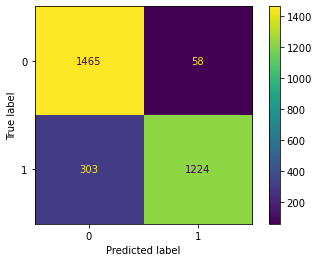

In [37]:
smt.plot_confusion_matrix(model, test, y_test)

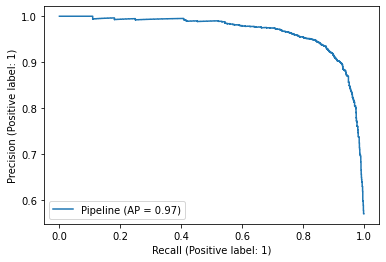

In [39]:
smt.plot_precision_recall_curve(model, test, y_test)

In [40]:
test['scores'] = model.predict_proba(test)[:,1]

In [41]:
test.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,num_samples,end_of_fade_in,loudness,...,mode_var,segments_duration_var,segments_duration_mean,pitches_mean,pitches_var,timbre_mean,timbre_var,tatums_duration_var,dev_flag,scores
0,0.707,0.830,0.2410,0.42300,0.000000,0.217,0.598,4500623,0.26689,-2.892,...,0.000000,0.112323,0.237337,0.393391,0.133352,12.062743,8.263999,0.004732,-1,0.926803
1,0.475,0.908,0.0912,0.04360,0.000000,0.883,0.815,4517016,0.28458,-4.345,...,0.471405,0.196960,0.248307,0.397819,0.133881,8.371906,6.716301,0.005685,-1,0.129777
2,0.531,0.786,0.0312,0.19700,0.000002,0.126,0.793,5974029,0.00000,-6.561,...,0.000000,0.133227,0.246750,0.352082,0.118124,8.135614,5.435024,0.000953,-1,0.040069
3,0.444,0.721,0.6710,0.07040,0.000001,0.765,0.721,6065220,0.30757,-10.826,...,0.314270,0.118472,0.229031,0.441833,0.158574,11.302083,12.892645,0.124879,-1,0.899756
4,0.665,0.751,0.0670,0.00195,0.000006,0.130,0.961,4210374,0.11156,-6.094,...,0.276385,0.204455,0.247983,0.398918,0.131242,7.406008,7.211849,0.001745,-1,0.026387


Test out different thresholds

In [79]:
test['preds'] = np.where(test['scores']>0.25, 1, 0)

In [80]:
prc = round(smt.precision_score(y_test, test['preds']), 2)
print(f'Precision on test set is {prc}')

recall = round(smt.recall_score(y_test, test['preds']), 2)
print(f'Recall on test set is {recall}')

Precision on test set is 0.91
Recall on test set is 0.9


In [81]:
print(smt.confusion_matrix(y_test, test['preds']))

[[1394  129]
 [ 150 1377]]
